## Quantum Annealing using Qamomile and QuTip

From here, we will introduce applications in quantum annealing using Qamomile and QuTip. The Hamiltonian we are considering this time is of the following form

$$
H(s) = s H_0 + (1 - s) H_1
$$

where $ H_0 $ is the Hamiltonian for the problem we want to solve and often formulated in terms of an Ising model, and $ H_1 $ is the Hamiltonian for the transverse magnetic field.

$$
H_0 = - \sum_{i < j} J_{ij} \sigma_i^z \sigma_j^z - \sum_{i=1}^N h_i \sigma_i^z, \quad H_1 = - \sum_{i=1}^N \sigma_i^x
$$


As $t$ increases and $1-t$ decreases, the system gradually evolves from the ground state of $H_1$ to the ground state of  $H_0$, which corresponds to the solution to the optimization problem. 

Quantum annealing relies on quantum tunneling to allow the system to escape local minima by passing through energy barriers, rather than needing to climb over them as in classical annealing.

First, let’s import the Qamomile library and other libraries used in this example.


In [1]:
import numpy as np
import qamomile.core.operator as qm_o
import matplotlib.pyplot as plt
import qamomile.qutip as qm_qt
import random

N = 4
J = {}
h = {}

for i in range(N-1):
    for j in range(i+1, N):
        J[(i, j)] = random.gauss(0, 1)

for i in range(N):
    h[i] = random.gauss(0, 1)

Define Hamiltonian $H_0$ using Qamomile 

In [2]:
H0= qm_o.Hamiltonian()
for (q1, q2), coeff in J.items():
    H0 -= coeff*qm_o.Z(q1) * qm_o.Z(q2) 
for q1, coeff in h.items():
    H0 -= coeff*qm_o.Z(q1)

Now transpile the qamomile’s hamiltonian to the qutip’s hamiltonian

In [3]:
qt_transpiler = qm_qt.QuTiPTranspiler()
qt_H0= qt_transpiler.transpile_hamiltonian(H0)

Same procedure for $H_1$

In [4]:
H1 = qm_o.Hamiltonian()
for q1, coeff in h.items():
    H1 -= qm_o.X(q1)
qt_H1= qt_transpiler.transpile_hamiltonian(H1)

We can calculate the energy spectrum by using `eigenenergies` form QuTiP. We will examine how the eigenenergy of the Hamiltonian changes as the parameter $s$ varies from 0 to 1.


In [5]:
from qutip import *
slist = np.linspace(0.0, 1.0, 101)
Elists = [[] for i in range(2**N)]

for s in slist:
    qt_H = s*qt_H0 + (1-s)*qt_H1
    evals = qt_H.eigenenergies()
    for i in range(2**N):
        Elists[i].append(evals[i])

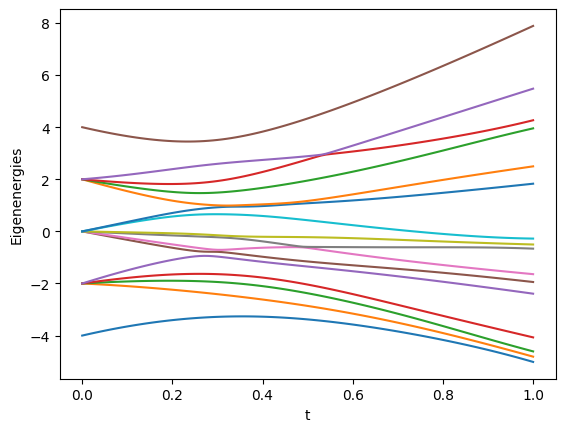

In [12]:
for i in range(2**N):
    plt.plot(slist, Elists[i], label=f"{i+1}th")

plt.xlabel("t")
plt.ylabel("Eigenenergies")
#plt.legend()
plt.show()


Next, let's calculate the dynamics of quantum annealing and try to determine the success probability of the annealing. In the Hamiltonian $H(s)$ introduced earlier, we define the annealing time $T$ with $s = t / T$. In quantum annealing, if $T$ is taken sufficiently large, the ground state can theoretically be obtained with 100\% probability. Therefore, we adjust $T$ and perform quantum annealing, and we examine how much the final state $|\psi(T)\rangle$ overlaps with the ground state $|\phi_0\rangle$ of $H_0$ by looking at $|\langle \phi_0 | \psi(T) \rangle|^2$. We refer to this as the success probability of quantum annealing.

Quantum annealing follows the Schrödinger equation for time evolution, but with QuTiP, we can numerically solve this Schrödinger equation easily with simple code.



In [29]:
_, eket0 = qt_H0.groundstate()

T = 10.0
def f0(t, args):
    return t/T

def f1(t, args):
    return 1 - t/T

The entire Hamiltonian is given as a list where each element is a pair consisting of a Hamiltonian and its coefficient.

We create the initial state $ \psi(t)$ at $t = 0$, which is the ground state of $H_1$.


In [18]:
H = [[qt_H0, f0], [qt_H1, f1]]
psi0 = tensor([Qobj([[1], [1]])/np.sqrt(2) for i in range(N)])


This time, we will not only look at the success probability but also examine how much $|\psi(t)\rangle$ overlaps with $|\phi_0\rangle$ at each moment. To solve the Schrödinger equation, we use `mesolve`. By providing the Hamiltonian to be solved (which may depend on time), the initial state, a list of times, a list of collapse operators (which is not relevant this time), and a list of operators for which we want to calculate the expectation values at each moment (this time, $\rho = |\phi_0\rangle \langle \phi_0|$, a function that converts the ket vector into a density operator), the dynamics can be calculated. `ket2dm` converts the ket vector to a density operator.


In [27]:
tlist = np.linspace(0.0, T, 101)

result = mesolve(H, psi0, tlist, [], [ket2dm(eket0)])

Among the calculation results, the expected value $|\langle \phi_0 | \psi(t) \rangle|^2$, which we wanted to calculate, is stored in `result.expect[0]`. Let's plot it.


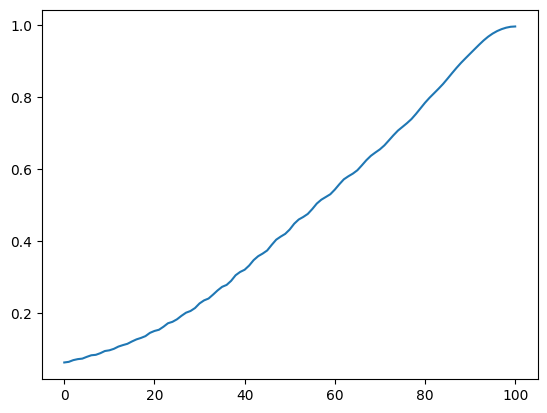

In [28]:
plt.plot(result.times, result.expect[0])
plt.show()

Masaphys. *PythonとQuTiPで量子アニーリングのダイナミクスを追う*. Qiita. Accessed October 30, 2024. [https://qiita.com/masaphys/items/38aeaee5313f81e15414](https://qiita.com/masaphys/items/38aeaee5313f81e15414)
